In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

import tifffile as tif

import xarray as xr
import os

from collections import defaultdict
from itertools import islice
import random

from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [85]:
sar_dir = '/data/exjobb/sarssw/sar_multiprocess/'   
bouy_survey_dir = '../bouy_survey/1h_survey/result_df'
svc_dir = './out/homogenity_svc.pkl'

with open(svc_dir, 'rb') as f: svc = pickle.load(f)
with open(bouy_survey_dir,'rb') as f_r: bouy_survey_df = pickle.load(f_r)

/home/sarssw/miniconda3/envs/glcm/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [108]:
# for getting the sigma0
def sar_gen(sar_dir, only_center = False, hom = True):
    sar_files = os.listdir(sar_dir)
    for file_name in sar_files:
        if not file_name.endswith('.tif'): continue
            
        if only_center:
            if not file_name.split('.')[0][-1] == '0': continue
                
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            for v in tif_img.asarray():   
                #print(tif_img.shaped_metadata[0])
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)

                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                pred = svc.predict([[graycoprops(glcm, gt)[0, 0] for gt in glcm_types]])[0]
                if pred == (0 if hom else 1):
                    yield v

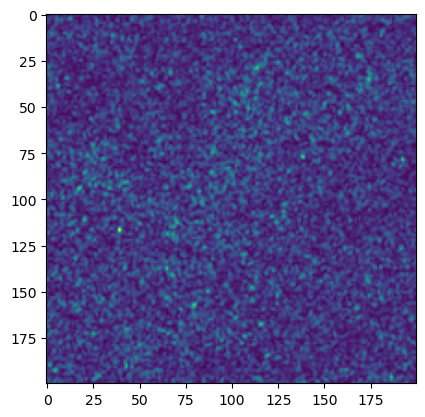

In [109]:
plt.imshow(next(sar_gen(sar_dir)))
plt.show()

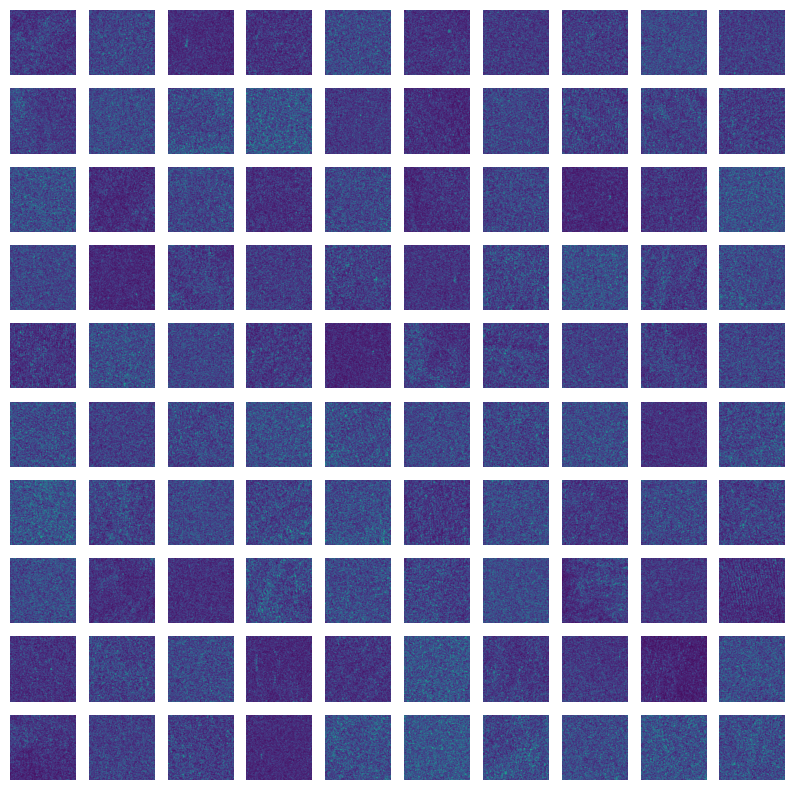

In [110]:
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
images = list(islice(sar_gen(sar_dir), 100))

for i, ax in enumerate(axes.flat):
    image = images[i]
    ax.imshow(image)
    ax.set_axis_off()

plt.show()

In [6]:
# todo change the names so that they dont use a dash as a separator
def unpack_name(name):
    sar_name, *bouy_name, ix = name.split('.')[0].split('-')
    return sar_name, '-'.join(bouy_name), ix

def get_value(name, variable_name = 'VHM0'):
    sar_name, bouy_name, _ = unpack_name(name)

    url_df = bouy_survey_df[bouy_survey_df.sar_url.str.contains(sar_name)]
    bouy_df = url_df[url_df.bouy_file_name.str.contains(bouy_name)]
    value = bouy_df[bouy_df.bouy_variable_name == variable_name].bouy_variable_value
    if len(value) == 1: return value.item()

In [115]:
def full_feature_extraction(sar_dir):
    feature_dict = defaultdict(list)
    #metadata_dict = defaultdict(list)
    sar_files = os.listdir(sar_dir)[:100]
    
    for file_name in tqdm(sar_files):
        if not file_name.endswith('.tif'): continue
        
        with tif.TiffFile(os.path.join(sar_dir, file_name)) as tif_img:
            
            #metadata_dict['file_name'].append(file_name)
            #for metadata_key, metadata_value in tif_img.shaped_metadata[0].items():
            #    metadata_dict[metadata_key].append(metadata_value)
            
            for v, pol in zip(tif_img.asarray(), tif_img.shaped_metadata[0]['pol']):
                if np.isnan(v).any(): continue

                ubyte = img_as_ubyte((v - v.min()) / (v.max() - v.min()))
                glcm = graycomatrix(ubyte, distances=[10], angles=[0], levels=256,
                                    symmetric=True, normed=True)

                all_glcm_types = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
                sar_glcm = {gt:graycoprops(glcm, gt)[0, 0] for gt in all_glcm_types}

                glcm_types =  ['homogeneity', 'dissimilarity', 'correlation']
                hom_test = svc.predict([[sar_glcm[gt] for gt in glcm_types]])[0] == 0
                
                #filename and polarization for given image
                feature_dict['file_name'].append(file_name)
                feature_dict['pol'].append(pol)
                
                #metadata from image
                for metadata_key, metadata_value in tif_img.shaped_metadata[0].items():
                    if metadata_key not in ['pol']:
                        feature_dict[metadata_key].append(metadata_value)
                
                #bool for if image is homogenous or not
                feature_dict['hom_test'].append(hom_test)
                
                #all features extracted from glcm
                for glcm_type, glcm_value in sar_glcm.items():
                    feature_dict[glcm_type].append(glcm_value)
                
                #features from sigma0 aggregations
                feature_dict['sigma_mean'].append(v.mean())
                feature_dict['sigma_var'].append(v.var())
                feature_dict['sigma_mean_over_var'].append(v.mean() / v.var())
                feature_dict['sigma_min'].append(v.min())
                feature_dict['sigma_max'].append(v.max())
                feature_dict['sigma_range'].append(v.max() - v.min())

    return feature_dict

In [116]:
feature_dict = full_feature_extraction(sar_dir)
feature_df = pd.DataFrame(feature_dict)
feature_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 80.28it/s]


,file_name,pol,sar_name,bouy_name,offset_index,time,lon,lat,shape,hom_test,...,homogeneity,energy,correlation,ASM,sigma_mean,sigma_var,sigma_mean_over_var,sigma_min,sigma_max,sigma_range
0,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,VV,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,NO_TS_MO_LichteilandGoeree1,7,2021-11-11T05:58:11.236014080,3.676897,51.925034,"[2, 200, 200]",False,...,0.442943,0.204799,0.008550,0.041943,0.008415,0.000108,77.756471,-0.001253,0.768479,0.769733
1,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,VH,S1B_IW_GRDH_1SDV_20211111T055808_20211111T0558...,NO_TS_MO_LichteilandGoeree1,7,2021-11-11T05:58:11.236014080,3.676897,51.925034,"[2, 200, 200]",False,...,0.741570,0.491548,0.006284,0.241620,0.000276,0.000037,7.414954,-0.001398,0.699442,0.700841
2,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,VV,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,NO_TS_MO_WielingenNoord,8,2021-10-12T05:59:01.882009600,3.421413,51.428128,"[2, 200, 200]",True,...,0.043234,0.015354,0.032252,0.000236,0.023053,0.000148,155.877878,-0.000364,0.135832,0.136196
3,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,VH,S1A_IW_GRDH_1SDV_20211012T055839_20211012T0559...,NO_TS_MO_WielingenNoord,8,2021-10-12T05:59:01.882009600,3.421413,51.428128,"[2, 200, 200]",True,...,0.051638,0.025296,-0.002753,0.000640,0.000179,0.000001,133.268145,-0.002136,0.009036,0.011173
4,S1B_IW_GRDH_1SDV_20210208T055759_20210208T0558...,VV,S1B_IW_GRDH_1SDV_20210208T055759_20210208T0558...,NO_TS_MO_Europlatform2,3,2021-02-08T05:58:01.719634944,3.269370,51.999414,"[2, 200, 200]",False,...,0.105392,0.035850,0.072078,0.001285,0.051920,0.000817,63.582755,0.000914,0.752119,0.751206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,S1A_IW_GRDH_1SDV_20210418T173320_20210418T1733...,VH,S1A_IW_GRDH_1SDV_20210418T173320_20210418T1733...,NO_TS_MO_DomburgerRassen,3,2021-04-18T17:33:28.571788544,3.406149,51.620806,"[2, 200, 200]",True,...,0.045916,0.016591,-0.015111,0.000275,-0.000151,0.000002,-95.909959,-0.002801,0.007839,0.010640
196,S1A_IW_GRDH_1SDV_20211108T173328_20211108T1733...,VV,S1A_IW_GRDH_1SDV_20211108T173328_20211108T1733...,NO_TS_MO_Akkaert,6,2021-11-08T17:33:34.570726144,2.813505,51.410597,"[2, 200, 200]",True,...,0.039159,0.014747,0.039725,0.000217,0.013800,0.000065,212.104338,-0.001799,0.075867,0.077667
197,S1A_IW_GRDH_1SDV_20211108T173328_20211108T1733...,VH,S1A_IW_GRDH_1SDV_20211108T173328_20211108T1733...,NO_TS_MO_Akkaert,6,2021-11-08T17:33:34.570726144,2.813505,51.410597,"[2, 200, 200]",True,...,0.044189,0.026289,-0.003689,0.000691,0.000134,0.000002,61.719827,-0.002907,0.008965,0.011872
198,S1A_IW_GRDH_1SDV_20211110T060649_20211110T0607...,VV,S1A_IW_GRDH_1SDV_20211110T060649_20211110T0607...,NO_TS_MO_OostendNorth,2,2021-11-10T06:07:13.792075520,2.874211,51.348178,"[2, 200, 200]",True,...,0.040796,0.013759,0.016430,0.000189,0.020249,0.000126,161.129478,-0.002085,0.115638,0.117723
